In [2]:
import multiprocessing
multiprocessing.set_start_method("fork")

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet

In [3]:
df = pd.read_csv('ecuador_dataset.csv')
df

,family,date,unit_sales,onpromotion,items,oil_price,precipitation,tavg,tmax,tmin,yellow maize,rice,white maize,wheat flour,wheat,potatoes
0,AUTOMOTIVE,2013-01-02,123.000,0.0,20.0,93.14,0.0,13.80,17.4,5.00,18.07,1.04,0.58,38.0,17.27,0.35
1,AUTOMOTIVE,2013-01-03,82.000,0.0,20.0,92.97,0.0,13.80,18.6,7.20,18.07,1.04,0.58,38.0,17.27,0.35
2,AUTOMOTIVE,2013-01-04,71.000,0.0,20.0,93.12,0.8,13.70,18.6,8.00,18.07,1.04,0.58,38.0,17.27,0.35
3,AUTOMOTIVE,2013-01-05,184.000,0.0,20.0,93.12,0.0,14.45,19.9,7.35,18.07,1.04,0.58,38.0,17.27,0.35
4,AUTOMOTIVE,2013-01-06,198.000,0.0,20.0,93.12,2.0,15.20,21.2,6.70,18.07,1.04,0.58,38.0,17.27,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55369,SEAFOOD,2017-08-10,433.118,0.0,8.0,48.54,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55370,SEAFOOD,2017-08-11,765.204,73.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55371,SEAFOOD,2017-08-12,613.881,6.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55372,SEAFOOD,2017-08-13,700.469,0.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30


In [11]:
m = Prophet(changepoint_prior_scale=0.1, mcmc_samples=400)
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=100000)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=100000)
m.add_seasonality(
    name='weekly', period=7, fourier_order=5, prior_scale=10000)
# TODO: add holidays from holidays.csv
m.add_country_holidays(country_name='US')
m.add_regressor('onpromotion')
m.add_regressor('oil_price')
m.add_regressor('precipitation')
m.add_regressor('tavg')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('potatoes')
m.add_regressor('yellow_maize')

In [6]:
future = df.copy()
future['date']=pd.to_datetime(future['date'])
future = future.loc[
    future['family'].isin(
        ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DELI', 'GROCERY I', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE']),
    ['family', 'date', 'unit_sales', 'onpromotion', 'oil_price', 'precipitation', 
     'tavg', 'tmax', 'tmin', 'yellow maize', 'potatoes']
]
print(future.info())
future = future.groupby(by='date').agg(
    unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'),
    onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'),
    oil_price = pd.NamedAgg(column='oil_price', aggfunc='first'),
    precipitation = pd.NamedAgg(column='precipitation', aggfunc='first'),
    tmax = pd.NamedAgg(column='tmax', aggfunc='first'),
    tmin = pd.NamedAgg(column='tmin', aggfunc='first'),
    tavg = pd.NamedAgg(column='tavg', aggfunc='first'),
    yellow_maize = pd.NamedAgg(column='yellow maize', aggfunc='first'),
    potatoes = pd.NamedAgg(column='potatoes', aggfunc='first')
)
future = future.loc['2015-05-01':'2017-04-30',:].reset_index()
future = future.rename(columns={'date': 'ds', 'unit_sales': 'y'})
future

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15102 entries, 5034 to 52017
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   family         15102 non-null  object        
 1   date           15102 non-null  datetime64[ns]
 2   unit_sales     15102 non-null  float64       
 3   onpromotion    15102 non-null  float64       
 4   oil_price      15102 non-null  float64       
 5   precipitation  15102 non-null  float64       
 6   tavg           15102 non-null  float64       
 7   tmax           15102 non-null  float64       
 8   tmin           15102 non-null  float64       
 9   yellow maize   15102 non-null  float64       
 10  potatoes       15102 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 1.4+ MB
None


,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,270556.880,2132.0,59.10,0.0,20.300000,4.066667,13.950000,21.766667,0.295333
1,2015-05-02,298407.713,488.0,59.10,0.0,21.000000,3.700000,13.400000,21.783333,0.295667
2,2015-05-03,320385.872,483.0,59.10,20.1,21.000000,6.000000,11.300000,21.800000,0.296000
3,2015-05-04,224808.293,432.0,58.92,16.0,19.000000,5.300000,12.100000,21.816667,0.296333
4,2015-05-05,198385.374,428.0,60.38,8.9,20.100000,6.800000,11.900000,21.833333,0.296667
...,...,...,...,...,...,...,...,...,...,...
722,2017-04-26,304676.099,5746.0,49.22,0.0,18.400000,8.000000,11.700000,21.271667,0.345333
723,2017-04-27,228141.292,3416.0,48.96,22.1,20.200000,7.800000,13.800000,21.160000,0.344000
724,2017-04-28,314574.574,5597.0,49.31,0.0,20.033333,7.716667,13.816667,21.048333,0.342667
725,2017-04-29,416518.395,3445.0,49.31,0.0,19.866667,7.633333,13.833333,20.936667,0.341333


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


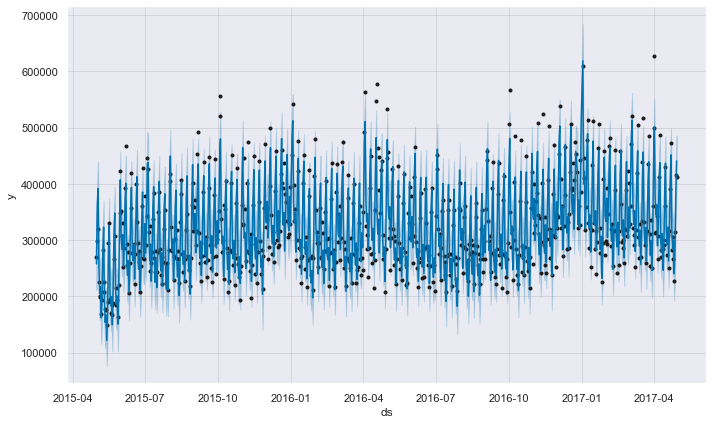

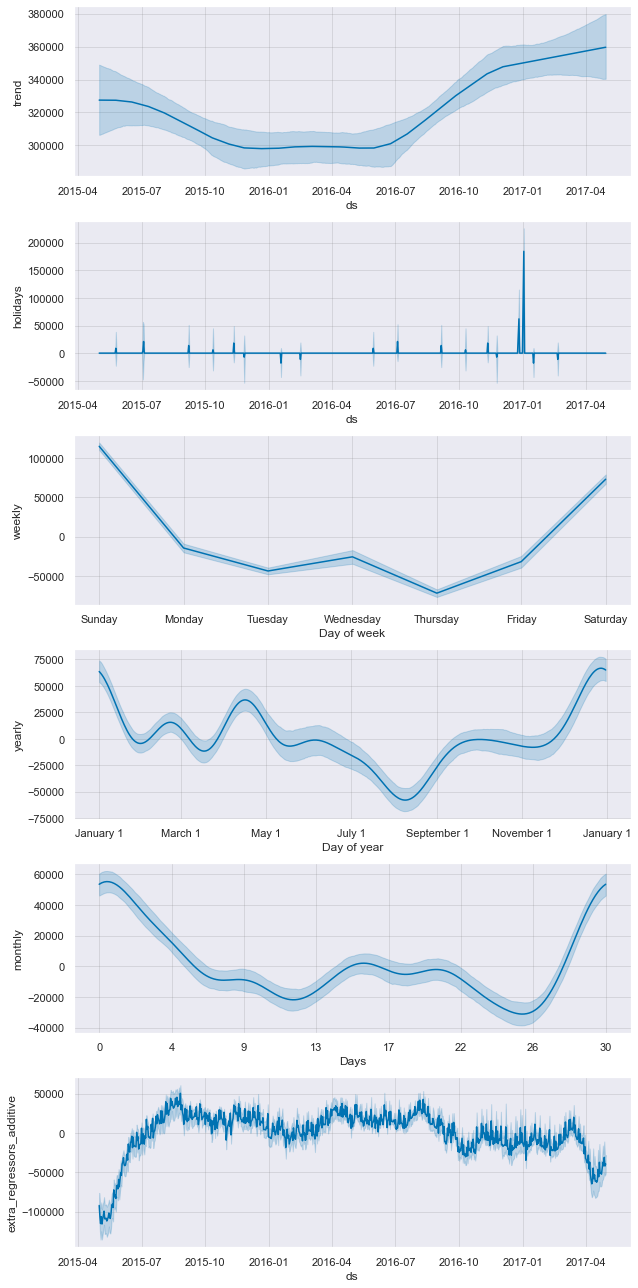

In [12]:
m.fit(future)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

(17106.0, 17198.0)

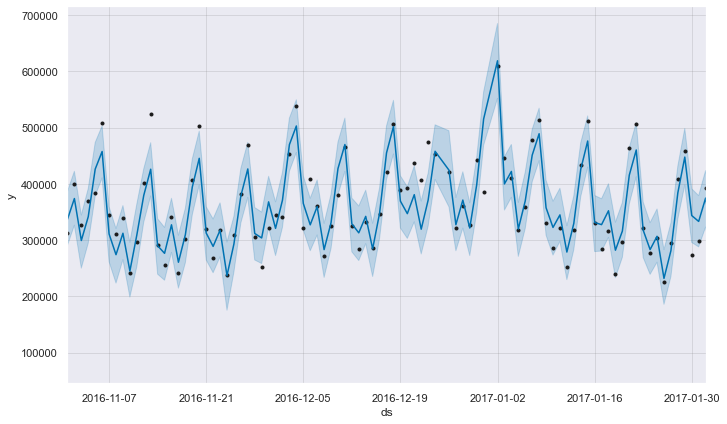

In [13]:
fig3 = m.plot(forecast)
ax = fig3.gca()
ax.set_xlim(pd.to_datetime(['2016-11-01', '2017-02-01'])) 

In [14]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365.25 days', period='60 days', horizon = '30 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2016-06-04 00:00:00 and 2017-03-31 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

(0.0, 800000.0)

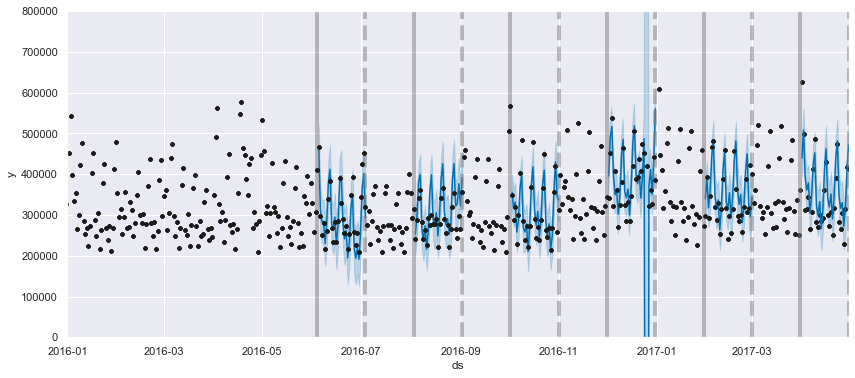

In [17]:
cutoffs = df_cv['cutoff'].unique()
fig = plt.figure(facecolor='w', figsize=(14, 6))
ax = fig.add_subplot(111)
for cut in cutoffs:
    cv = df_cv[df_cv['cutoff'].values == cut]
    ax.plot(m.history['ds'].values, m.history['y'], 'k.')
    ax.plot(cv['ds'].values, cv['yhat'], ls='-', c='#0072B2')
    ax.fill_between(cv['ds'].values, cv['yhat_lower'],
                    cv['yhat_upper'], color='#0072B2',
                    alpha=0.2)
    ax.axvline(x=pd.to_datetime(cut), c='gray', lw=4, alpha=0.5)
    ax.set_ylabel('y')
    ax.set_xlabel('ds')
    ax.axvline(x=pd.to_datetime(cut) + pd.Timedelta('30 days'), c='gray', lw=4,
               alpha=0.5, ls='--')
ax.set_xlim([pd.to_datetime('2016-01-01'),m.history['ds'].tail(1)])
ax.set_ylim(0,800000)

(0.0, 800000.0)

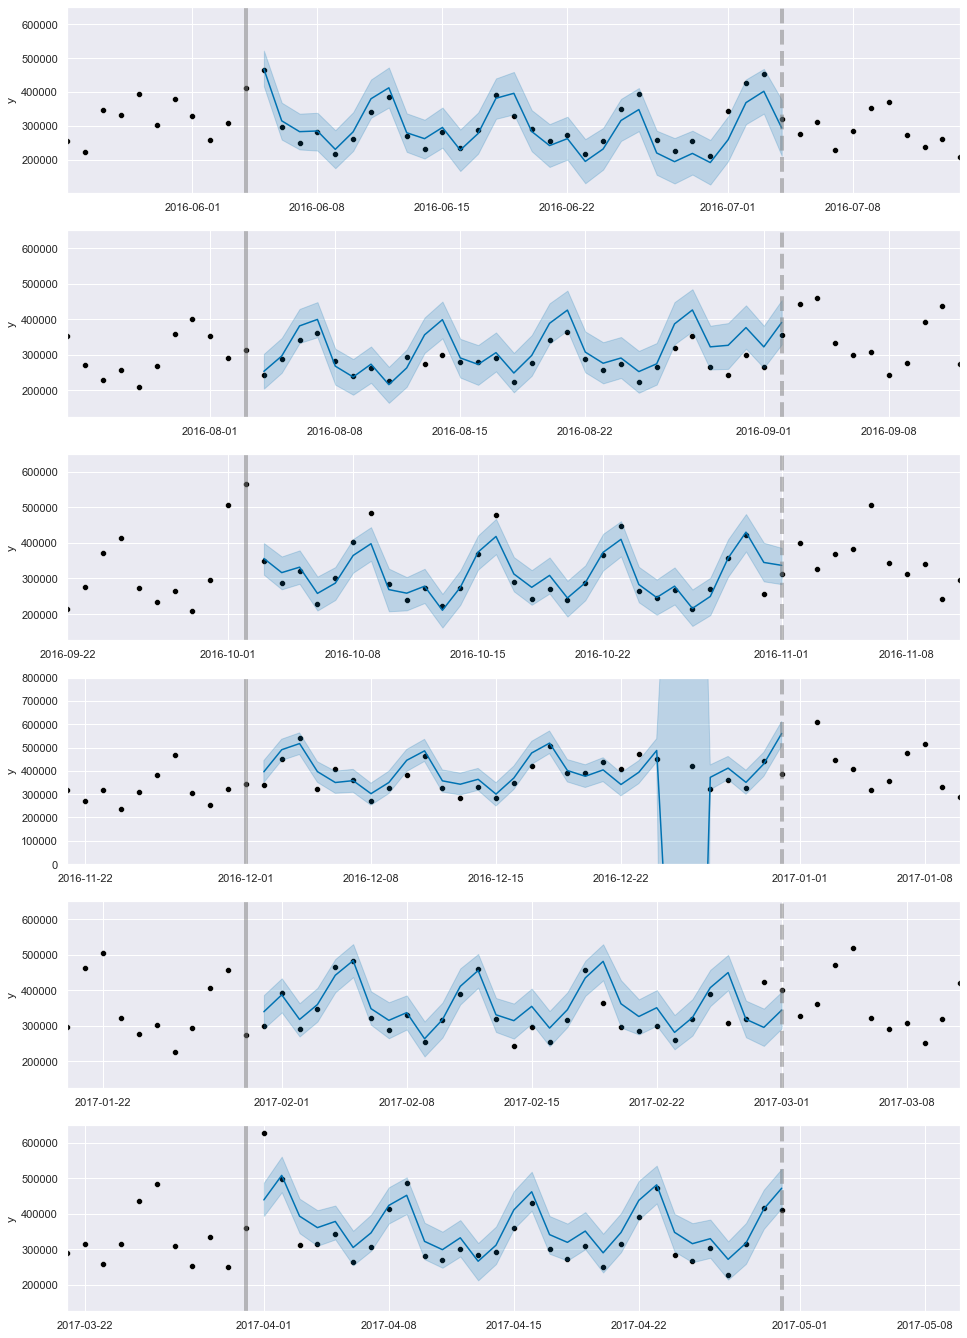

In [19]:
fig, ax = plt.subplots(6,1, figsize=(16,24))
cutoffs = df_cv['cutoff'].unique()
for i, cut in enumerate(cutoffs):
    cv = df_cv[df_cv['cutoff'].values == cut]
    sns.scatterplot(x=m.history['ds'].values, y=m.history['y'], color='black', ax=ax[i])
    sns.lineplot(x=cv['ds'].values, y=cv['yhat'], color='#0072B2', ax=ax[i])
    ax[i].fill_between(cv['ds'].values, cv['yhat_lower'],
                    cv['yhat_upper'], color='#0072B2',
                    alpha=0.2)
    ax[i].axvline(x=pd.to_datetime(cut), c='gray', lw=4, alpha=0.5)
    ax[i].axvline(x=pd.to_datetime(cut) + pd.Timedelta('30 days'), c='gray', lw=4,
               alpha=0.5, ls='--')
    ax[i].set_xlim([pd.to_datetime(cut) - pd.Timedelta('10 days'), pd.to_datetime(cut) + pd.Timedelta('40 days')])
ax[3].set_ylim(0,800000)

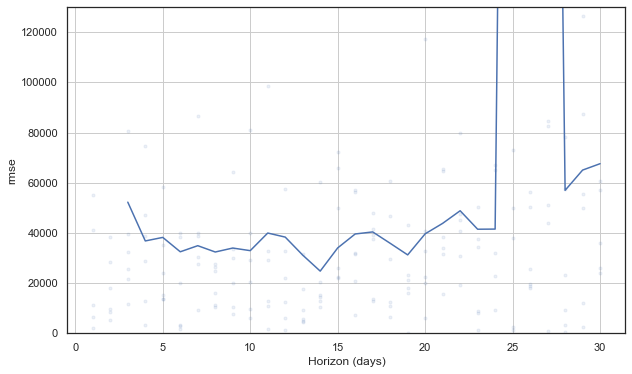

In [27]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
df_p = performance_metrics(df_cv)
df_p.head()

with sns.axes_style('white'):
    fig = plot_cross_validation_metric(df_cv, metric='rmse')
    ax = fig.gca()
    ax.set_ylim(0,130000)